# Pairs Trading - finding pairs based on Clustering

The code here has been adapted from [O'Rielly's Machine Learning & Data Science Blueprints for Finance](https://github.com/tatsath/fin-ml/blob/bc10f73984d23e1e968b63c4066228d603ca02fb/Chapter%208%20-%20Unsup.%20Learning%20-%20Clustering/Case%20Study1%20-%20Clustering%20for%20Pairs%20Trading/ClusteringForPairsTrading.ipynb) online resources, and follows their outline to use clustering in identifying possible pairs-trading opportunities from this [investment portfolio](https://docs.google.com/spreadsheets/d/1EZj5M7dXGy-48i0PydZQa5gpUOYCQHDFRBlp_rU1sdo/edit#gid=1736594093).

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Data Transformation](#3.2)  
* [5.Evaluate Algorithms and Models](#5)        
    * [5.1. k-Means Clustering](#5.1)
        * [5.1.1 Finding right number of clusters](#5.1.1)
        * [5.1.2 Clustering and Visualization](#5.1.2)
    * [5.2. Hierarchial Clustering (Agglomerative Clustering)](#5.2)
        * [5.2.1. Building Hierarchy Graph/ Dendogram](#5.2.1)
        * [5.2.2. Clustering and Visualization](#5.2.1) 
    * [5.3. Affinity Propagation Clustering](#5.3)
        * [5.3.1 Visualising the cluster](#5.2.1)
    * [5.4. Cluster Evaluation](#5.4)        
* [6.Pair Selection](#6)        
    * [6.1 Cointegration and Pair Selection Function](#6.1)    
    * [6.2. Pair Visualization](#6.2)   
* [7.Implement a Pairs Trading Methodology](#7)
* [8.Conclusion](#8)

<a id='0'></a>
# 1. Problem Definition

Our goal in this case study is to perform clustering analysis on the stocks of the aforementioned investment portfolo and identify possible pairs trading opportunities. 


The data of the stocks is obtained using the `yfinance` package and a `.csv` version of the investment portfolio, which is imported below. Data for this analysis includes closing prices for all of the portfolio's assets three years prior to 2023-12-17.

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas_datareader as dr
import datetime as dt
from dateutil.relativedelta import relativedelta
import yfinance as yf



#Import Model Packages 
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle

<a id='1.2'></a>
## 2.2. Loading the Data

In [2]:
#The data already obtained from yahoo finance is imported.
# dataset = read_csv('SP500Data.csv',index_col=0)

investments = pd.read_csv('../Portfolio/investments.csv')
investments['weights'] = investments['initial_investment'] / investments['initial_investment'].sum()
portfolio_start = investments.initial_investment.sum()

tickers = list(investments['ticker'].values)
end_date = dt.date(2023,12,16)
start_date = end_date - relativedelta(years=3)
dataset = pd.DataFrame()

# have to make separate dataframes because crypto markets don't close
dataset_crypto = pd.DataFrame()

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    tmp = tmp.history(start=start_date, end=end_date)['Close']
    if row['investment_type'] == 'crypto':
        dataset_crypto[ticker] = tmp
    else:
        dataset[ticker] = tmp

        
dataset = dataset.reset_index()
dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date
dataset = dataset.set_index('Date')

# need to remove times since they "close" at different times
dataset_crypto = dataset_crypto.reset_index()
dataset_crypto['Date'] = pd.to_datetime(dataset_crypto['Date']).dt.date
dataset_crypto = dataset_crypto.set_index('Date')

dataset = dataset.join(dataset_crypto)
# only include stocks in final dataset
dataset = dataset.drop(columns=['BNDX', 'GOVT', 'LQD', 'BTC-USD', 'ETH-USD'])
dataset.head()

,XOM,PCCYF,NEE,BHP,APD,RTX,UNP,AMZN,TSLA,HESAY,...,RY,MSFT,TCEHY,SNOW,GOOGL,AMX,NG,IBDRY,PLD,PSA
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-16,38.290344,0.234027,69.515694,52.696289,250.743774,65.599403,186.067627,162.048004,207.589996,103.358002,...,73.107086,213.545044,69.302711,329.970001,87.859497,13.385430,10.48,48.475445,92.280182,197.561279
2020-12-17,38.097580,0.234027,70.094681,53.841690,250.464020,65.664467,189.202255,161.804001,218.633331,104.962814,...,73.062561,213.681366,70.444336,325.540009,87.025497,13.246289,10.94,49.320175,93.497948,203.331787
2020-12-18,37.440426,0.234027,69.581062,53.386784,251.349899,65.227577,190.512314,160.082504,231.666672,103.613976,...,72.430481,212.873077,70.472404,334.250000,86.310997,13.162804,10.42,49.399372,91.164688,200.157990
2020-12-21,36.756985,0.234027,69.478333,53.273052,246.631546,64.762810,189.473618,160.309006,216.619995,103.446617,...,71.878532,216.768448,69.143623,349.850006,86.727997,13.051490,10.46,48.660225,90.402420,199.965668
2020-12-22,36.134869,0.226477,69.767830,52.501331,246.183975,64.372383,188.565979,160.326004,213.446671,103.161087,...,71.335480,218.083176,68.582169,341.160004,86.011002,12.847417,10.01,48.651428,90.774261,203.008286


In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [5]:
# shape
dataset.shape

(755, 27)

In [6]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,XOM,PCCYF,NEE,BHP,APD,RTX,UNP,AMZN,TSLA,HESAY,...,RY,MSFT,TCEHY,SNOW,GOOGL,AMX,NG,IBDRY,PLD,PSA
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-16,38.290344,0.234027,69.515694,52.696289,250.743774,65.599403,186.067627,162.048004,207.589996,103.358002,...,73.107086,213.545044,69.302711,329.970001,87.859497,13.385430,10.48,48.475445,92.280182,197.561279
2020-12-17,38.097580,0.234027,70.094681,53.841690,250.464020,65.664467,189.202255,161.804001,218.633331,104.962814,...,73.062561,213.681366,70.444336,325.540009,87.025497,13.246289,10.94,49.320175,93.497948,203.331787
2020-12-18,37.440426,0.234027,69.581062,53.386784,251.349899,65.227577,190.512314,160.082504,231.666672,103.613976,...,72.430481,212.873077,70.472404,334.250000,86.310997,13.162804,10.42,49.399372,91.164688,200.157990
2020-12-21,36.756985,0.234027,69.478333,53.273052,246.631546,64.762810,189.473618,160.309006,216.619995,103.446617,...,71.878532,216.768448,69.143623,349.850006,86.727997,13.051490,10.46,48.660225,90.402420,199.965668
2020-12-22,36.134869,0.226477,69.767830,52.501331,246.183975,64.372383,188.565979,160.326004,213.446671,103.161087,...,71.335480,218.083176,68.582169,341.160004,86.011002,12.847417,10.01,48.651428,90.774261,203.008286


In [7]:
# describe data
dataset.describe()

,XOM,PCCYF,NEE,BHP,APD,RTX,UNP,AMZN,TSLA,HESAY,...,RY,MSFT,TCEHY,SNOW,GOOGL,AMX,NG,IBDRY,PLD,PSA
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,...,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,81.200195,0.440000,73.962347,55.958766,266.647168,85.389267,210.772431,138.446784,246.457532,155.388209,...,91.794063,280.527526,50.935414,211.015192,118.558648,17.532286,6.405894,44.463814,119.868822,278.294835
std,24.315653,0.139785,7.399301,5.834968,23.623997,9.272841,15.901366,27.527571,55.598085,35.488768,...,7.199783,40.488370,14.526929,69.372546,17.578996,2.559001,1.839975,3.981839,16.251820,35.666016
min,36.117352,0.226477,48.921902,42.485218,208.940094,60.886513,180.749542,81.820000,108.099998,101.140541,...,71.335480,206.698898,24.208784,113.300003,83.430000,11.780663,3.310000,33.913349,87.297600,186.947052
25%,56.081469,0.354814,70.027866,52.075964,246.999229,80.131416,199.168472,115.040001,210.766670,126.015251,...,88.416340,246.209373,40.599737,153.264999,103.809750,16.263865,4.795000,41.651205,109.585155,266.540070
50%,84.419853,0.398600,73.981087,56.783283,272.141296,85.086632,207.870377,140.570007,240.080002,147.780319,...,92.536606,277.667847,45.419750,180.949997,119.099998,17.801233,6.160000,44.439999,119.539703,279.586090
75%,104.461861,0.506809,79.454285,60.352905,283.712601,93.921944,221.405457,163.523247,279.791672,183.578865,...,95.890823,314.055695,58.088171,267.669998,134.515007,19.503712,7.720000,47.634352,125.505386,293.500107
max,119.110809,0.750000,88.899986,69.291557,317.674896,102.543854,265.163300,186.570496,409.970001,223.550003,...,109.649910,382.700012,92.734238,401.890015,149.838501,22.336884,10.940000,53.895824,164.903610,379.258026


<a id='3'></a>
# 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [8]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Getting rid of the columns with more than 30% missing values. 

In [9]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(755, 27)

Given that there are null values drop the rown contianing the null values.

In [10]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,XOM,PCCYF,NEE,BHP,APD,RTX,UNP,AMZN,TSLA,HESAY,...,RY,MSFT,TCEHY,SNOW,GOOGL,AMX,NG,IBDRY,PLD,PSA
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-16,38.290344,0.234027,69.515694,52.696289,250.743774,65.599403,186.067627,162.048004,207.589996,103.358002,...,73.107086,213.545044,69.302711,329.970001,87.859497,13.385430,10.48,48.475445,92.280182,197.561279
2020-12-17,38.097580,0.234027,70.094681,53.841690,250.464020,65.664467,189.202255,161.804001,218.633331,104.962814,...,73.062561,213.681366,70.444336,325.540009,87.025497,13.246289,10.94,49.320175,93.497948,203.331787


<a id='3.2'></a>
## 4.2. Data Transformation

For the purpose of clustering, we will be using annual
returns and variance as the variables as they are the indicators of the stock performance and its volatility. Let us prepare the return and volatility variables from the
data.

In [11]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data=returns
#format the data as a numpy array to feed into the K-Means algorithm
#data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

All the variables should be on the same scale before applying clustering, otherwise a feature with large values will dominate the result. We use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset
X.head(2)

,Returns,Volatility
XOM,1.922544,-0.180674
PCCYF,2.101752,0.439363


The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

<a id='4'></a>
# 5. Evaluate Algorithms and Models

We will look at the following models:

1. KMeans
2. Hierarchical Clustering (Agglomerative Clustering)
3. Affinity Propagation 

<a id='5.1'></a>
## 5.1. K-Means Clustering


<a id='5.1.1'></a>
### 5.1.1. Finding optimal number of clusters

In this step we look at the following metrices:

1. Sum of square errors (SSE) within clusters
2. Silhouette score.

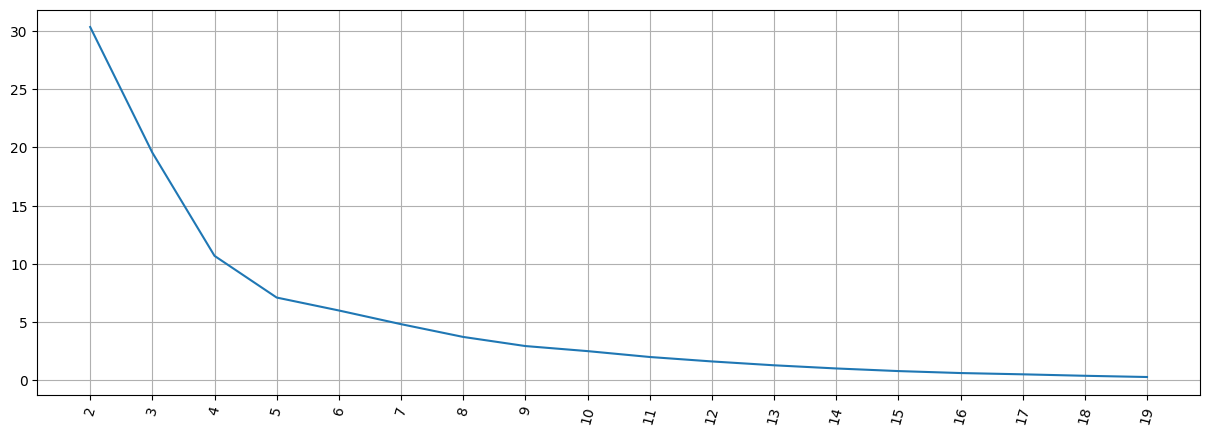

In [13]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

Inspecting the sum of squared errors chart, it appears the elbow “kink” occurs 5 or 6
clusters for this data. Certainly, we can see that as the number of clusters increase pass
6, the sum of square of errors within clusters plateaus off.

#### Silhouette score

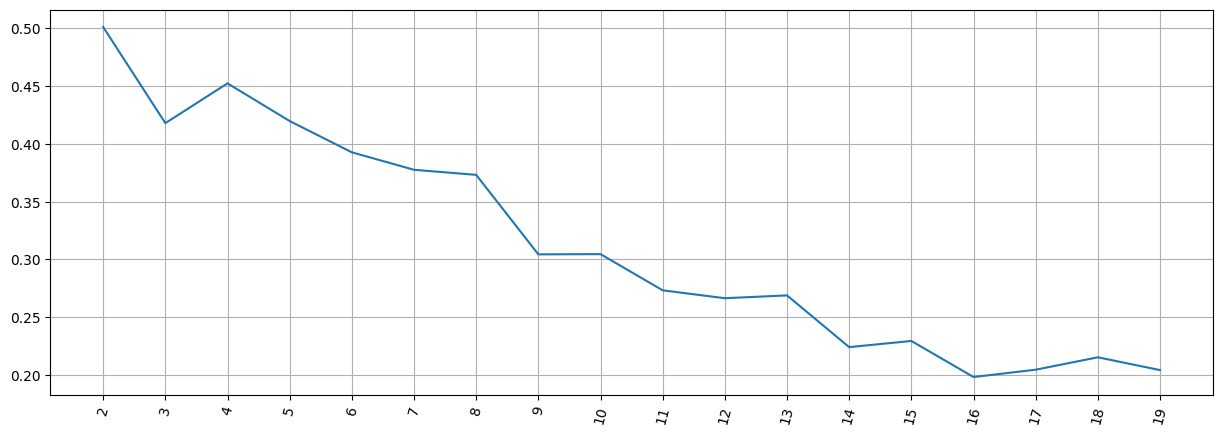

In [14]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

From the silhouette score chart, we can see that there are various parts of the graph
where a kink can be seen. Since there is not much a difference in SSE after 7 clusters,
we would prefer 7 clusters in the K-means model.

<a id='5.1.2'></a>
### 5.1.2.  Clustering and Visualisation

Let us build the k-means model with six clusters and
visualize the results.

In [15]:
nclust=7

In [16]:
#Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=7)

In [17]:
#Extracting labels 
target_labels = k_means.predict(X)

Visualizing how your clusters are formed is no easy task when the number of variables/dimensions in your dataset is very large. One of the methods of visualising a cluster in two-dimensional space.

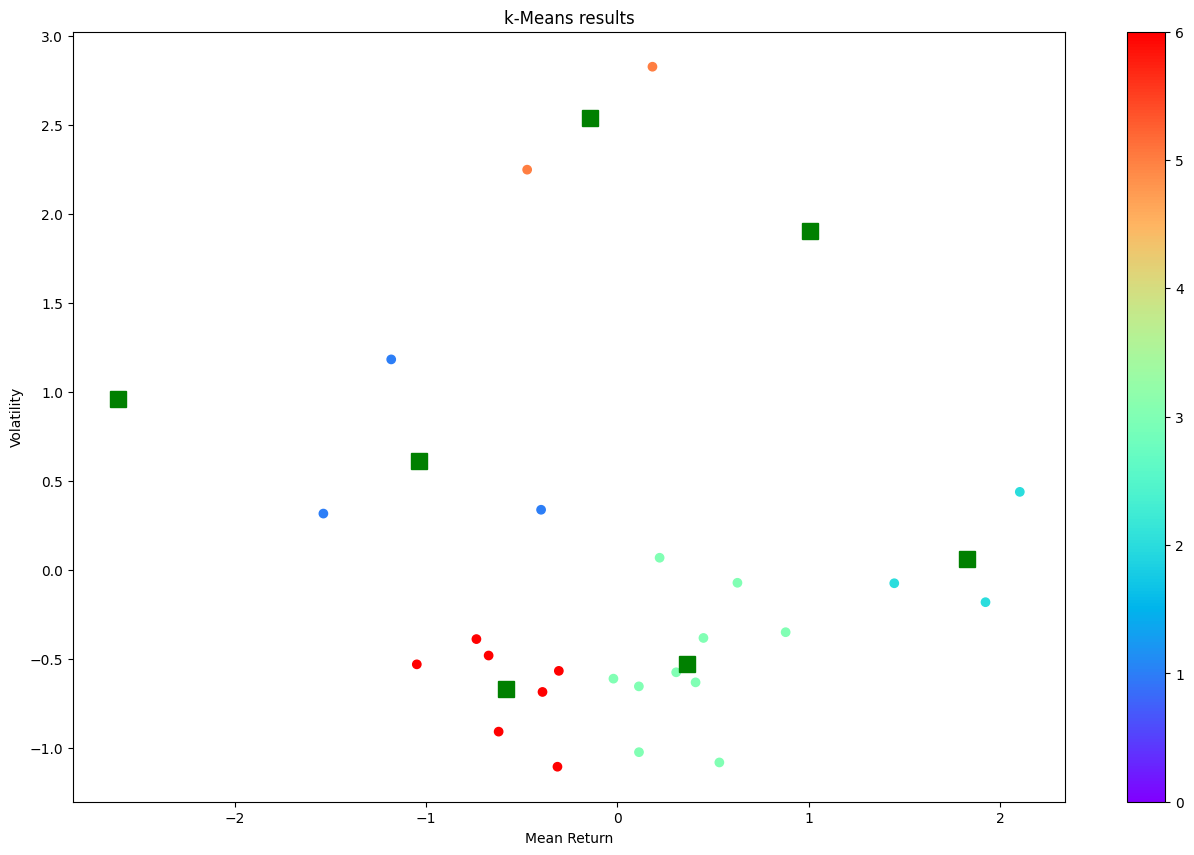

In [18]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

Let us check the elements of the clusters

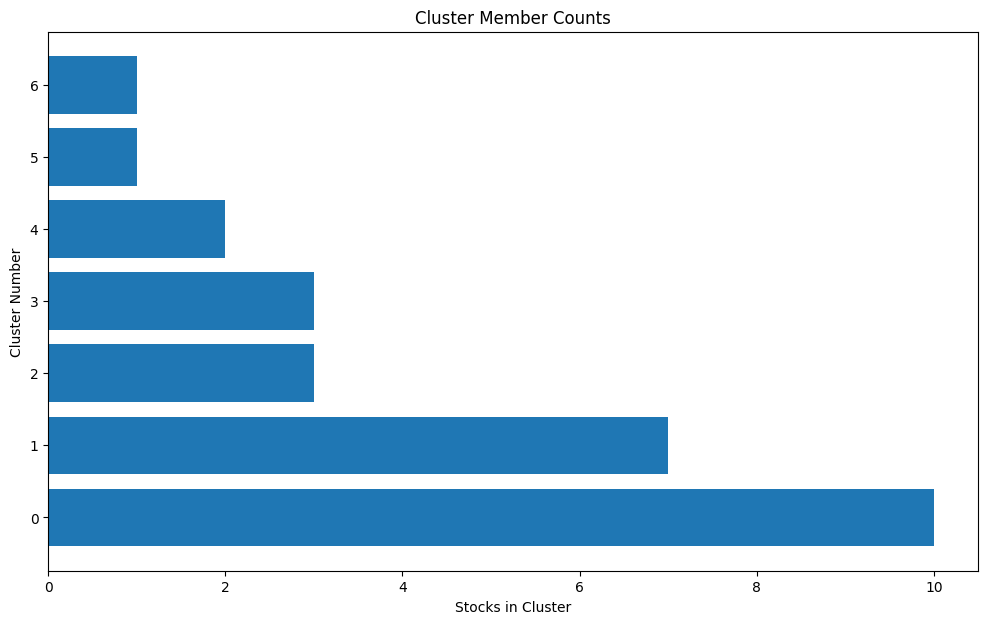

In [19]:
# show number of stocks in each cluster
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

The number of stocks in a cluster range from 1 to 10. Although, the distribution is not equal, a good number of clusters with a significant number of stocks.

<a id='5.2'></a>
## 5.2. Hierarchical Clustering (Agglomerative Clustering)

In the first step we look at the hierarchy graph and check for the number of clusters

<a id='5.2.1'></a>
### 5.2.1. Building Hierarchy Graph/ Dendogram

The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and the method to minimize distances as parameters. We use 'ward' as the method since it minimizes then variants of distances between the clusters.

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

#Calulate linkage
Z= linkage(X, method='ward')
Z[0]

array([ 2.        , 10.        ,  0.11230859,  2.        ])

The best way to visualize an agglomerate clustering algorithm is through a dendogram, which displays a cluster tree, the leaves being the individual stocks and the root being the final single cluster. The "distance" between each cluster is shown on the y-axis, and thus the longer the branches are, the less correlated two clusters are.

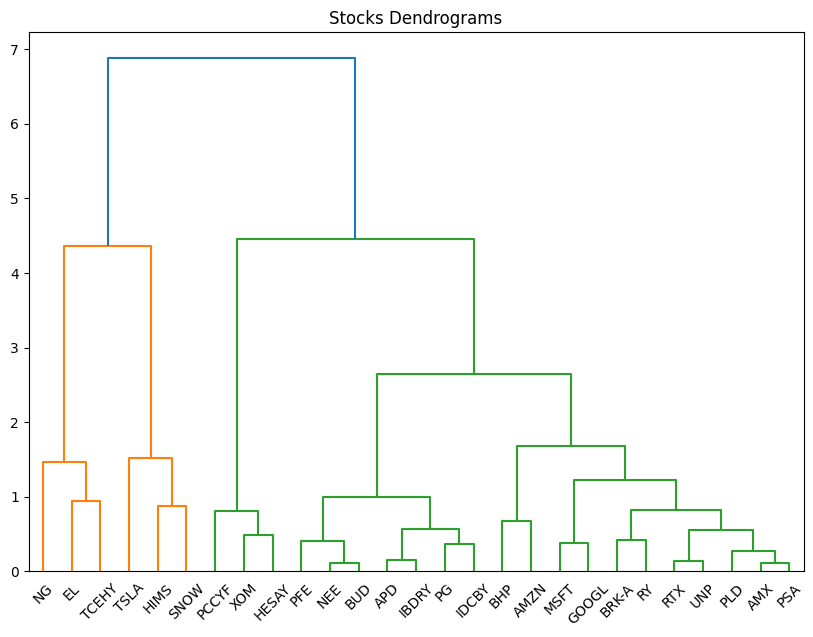

In [21]:
#Plot Dendogram
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendrograms")
dendrogram(Z,labels = X.index)
plt.show()

Once one big cluster is formed, the longest vertical distance without any horizontal line passing through it is selected and a horizontal line is drawn through it. The number of vertical lines this newly created horizontal line passes is equal to number of clusters.
Then we select the distance threshold to cut the dendrogram to obtain the selected clustering level. The output is the cluster labelled for each row of data. As expected from the dendrogram, a cut at 5 gives us two clusters.

In [22]:
distance_threshold = 5
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([2, 1], dtype=int32)

<a id='5.2.2'></a>
### 5.2.2.  Clustering and Visualisation

In [23]:
nclust = 4
hc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = hc.fit_predict(X)

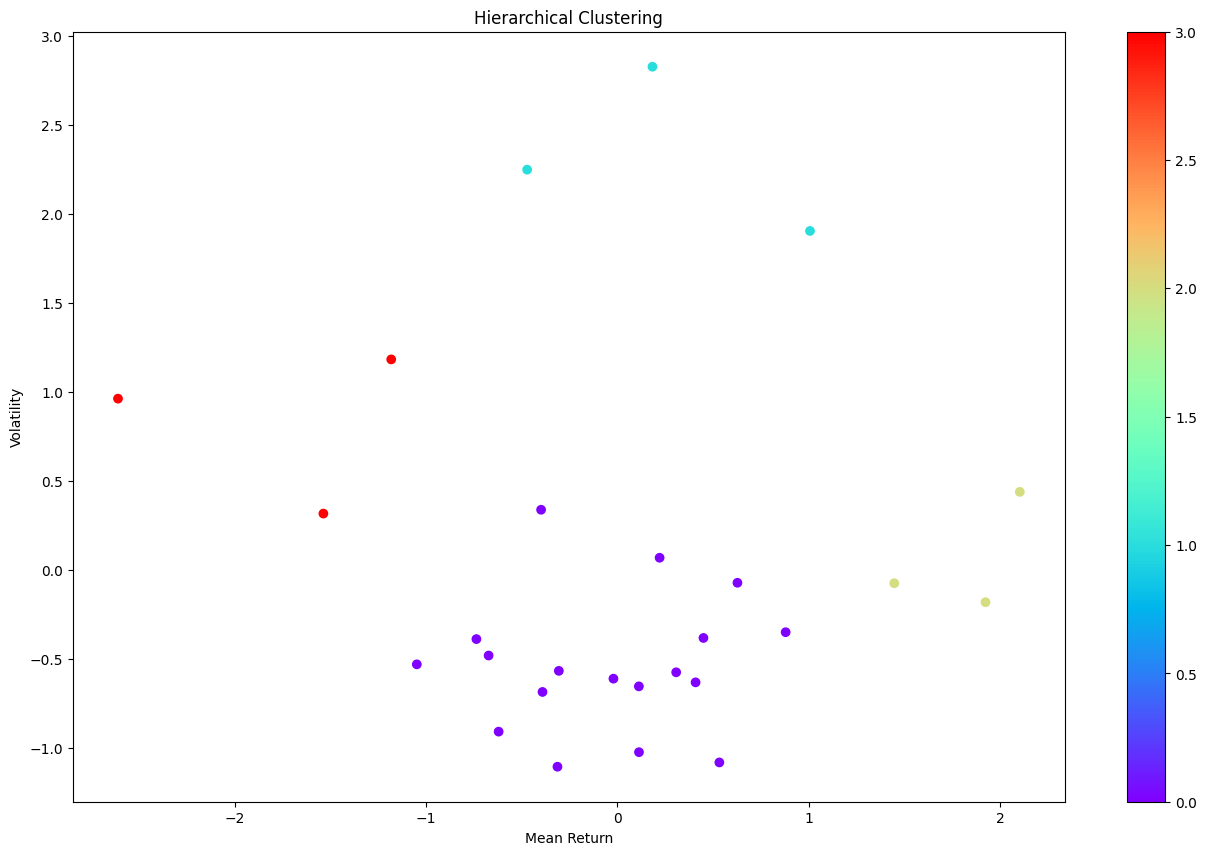

In [24]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

Similar to the plot of k-means clustering, we see that there are some distinct clusters
separated by different colors. 

<a id='5.3'></a>
## 5.3. Affinity Propagation

In [25]:
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)

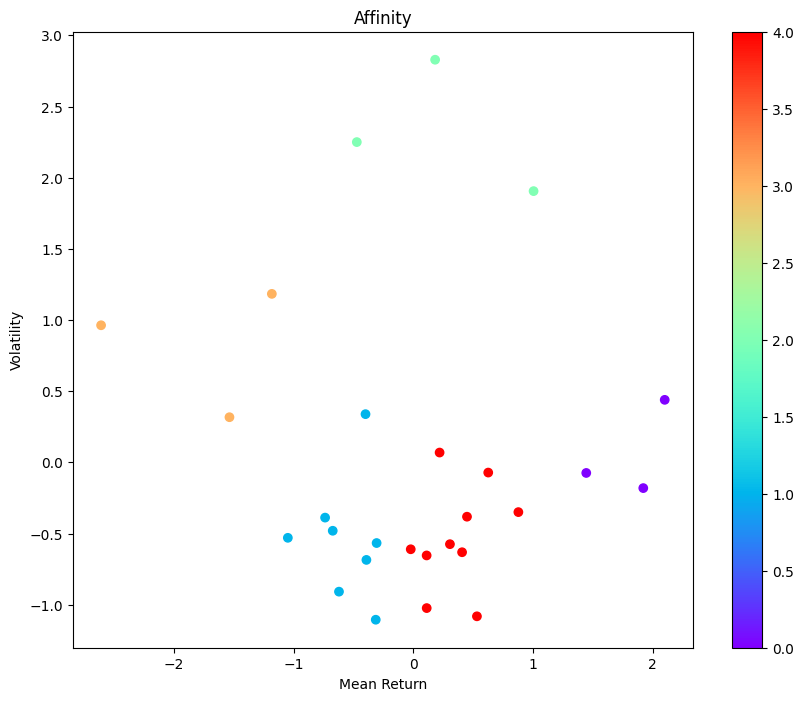

In [26]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

Similar to the plot of k-means clustering, we see that there are some distinct clusters separated by different colors. 

<a id='5.3.1'></a>
### 5.3.1 Cluster Visualisation

In [27]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

Estimated number of clusters: 5


<Figure size 640x480 with 0 Axes>

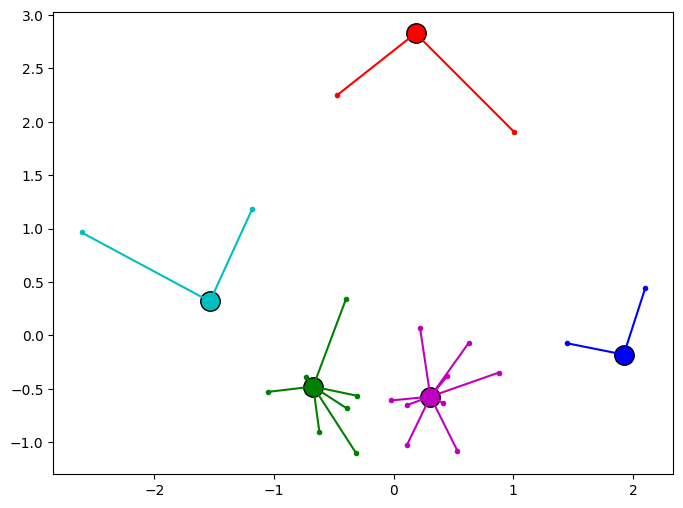

In [28]:
no_clusters = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % no_clusters)
# Plot exemplars

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8,6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(no_clusters), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

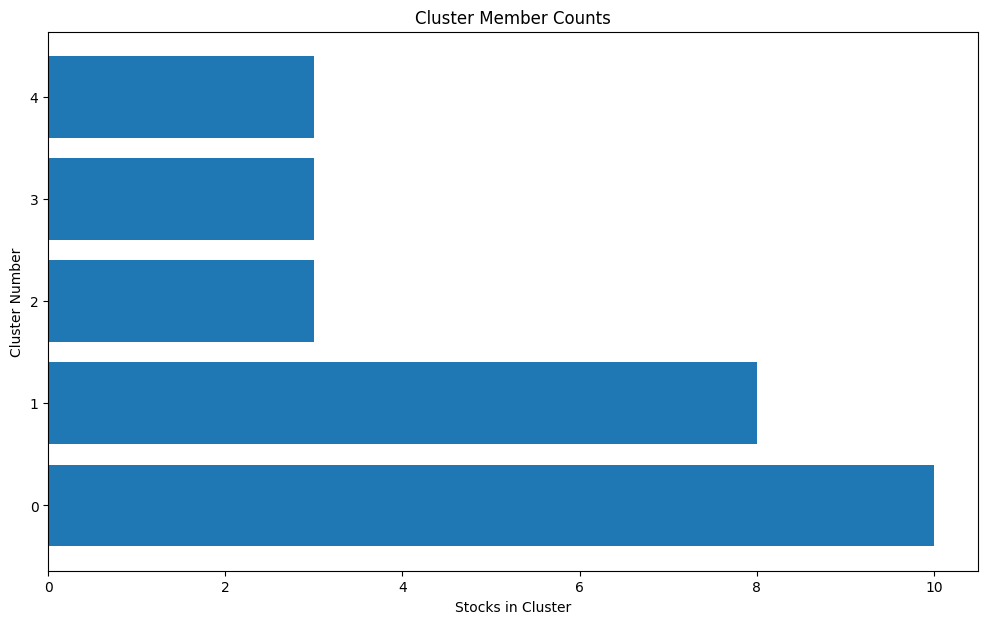

In [29]:
# show number of stocks in each cluster
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_ap.value_counts())), # cluster labels, y axis
    clustered_series_ap.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

<a id='5.4'></a>
## 5.4. Cluster Evaluation

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

In [30]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.37755574405329634
hc 0.4972114678586288
ap 0.4197366207734914


Given the affinity propagation performs the best, we go ahead with the affinity propagation and use the 5 clusters as specified by this clustering method

### Visualising the return within a cluster

The understand the intuition behind clustering, let us visualize the results of the clusters.

In [31]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

In [32]:
# get the number of stocks in each cluster
counts = clustered_series_ap.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]
cluster_vis_list

[3, 2, 0, 1, 4]

In [33]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 5
Pairs to evaluate: 164


<Figure size 1200x700 with 0 Axes>

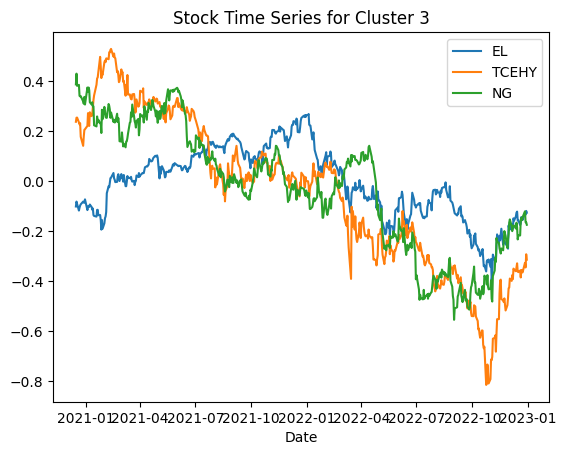

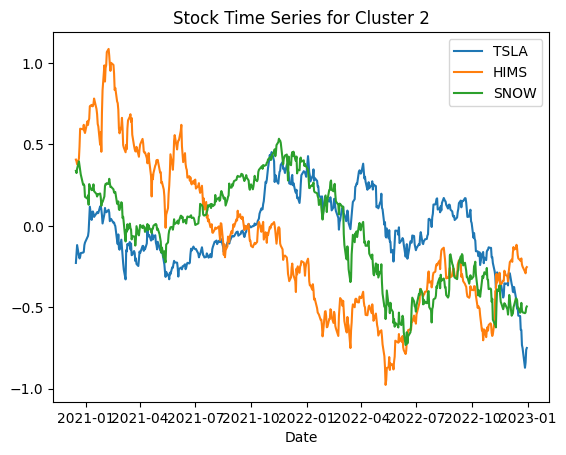

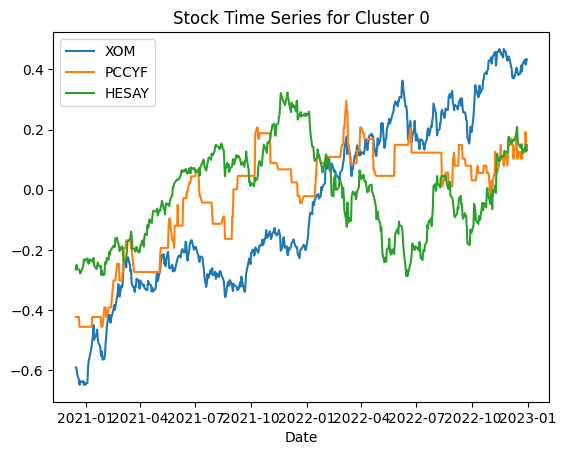

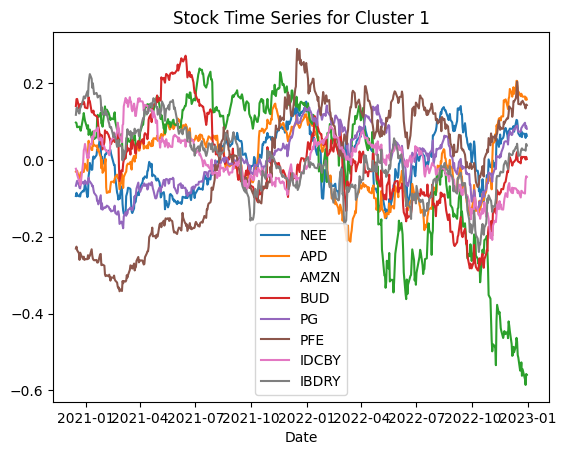

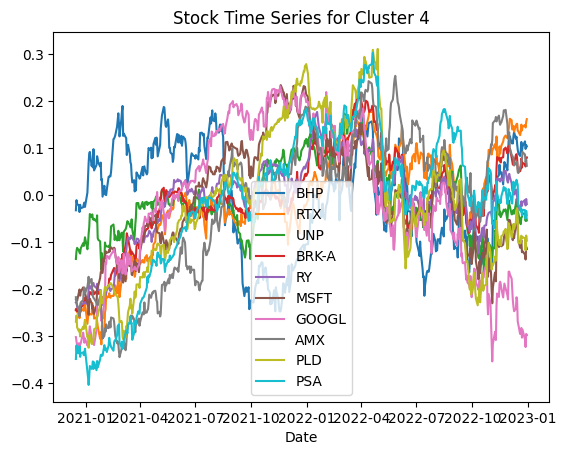

In [34]:
plt.figure(figsize=(12,7))

cutoff_date = dt.date(2023,1,1)


for clust in cluster_vis_list:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(dataset.loc[:cutoff_date, tickers].mean())
    data = np.log(dataset.loc[:cutoff_date, tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)
plt.show()

Looking at the charts above, across all the clusters with small number of stocks, we
see similar movement of the stocks under different clusters, which corroborates the
effectiveness of the clustering technique.

<a id='6'></a>
# 6. Pairs Selection

<a id='6.1'></a>
## 6.1. Cointegration and Pair Selection Function

In [35]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [36]:
from statsmodels.tsa.stattools import coint
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index   
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        dataset[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [37]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [38]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

Number of pairs found : 1
In those pairs, there are 2 unique tickers.


In [39]:
pairs

[('NEE', 'PFE')]

<a id='6.2'></a>
## 6.2. Pair Visualization

In [40]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

In [41]:
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

In [42]:
X_tsne = TSNE(learning_rate=50, perplexity=1, random_state=1337).fit_transform(X_pairs)

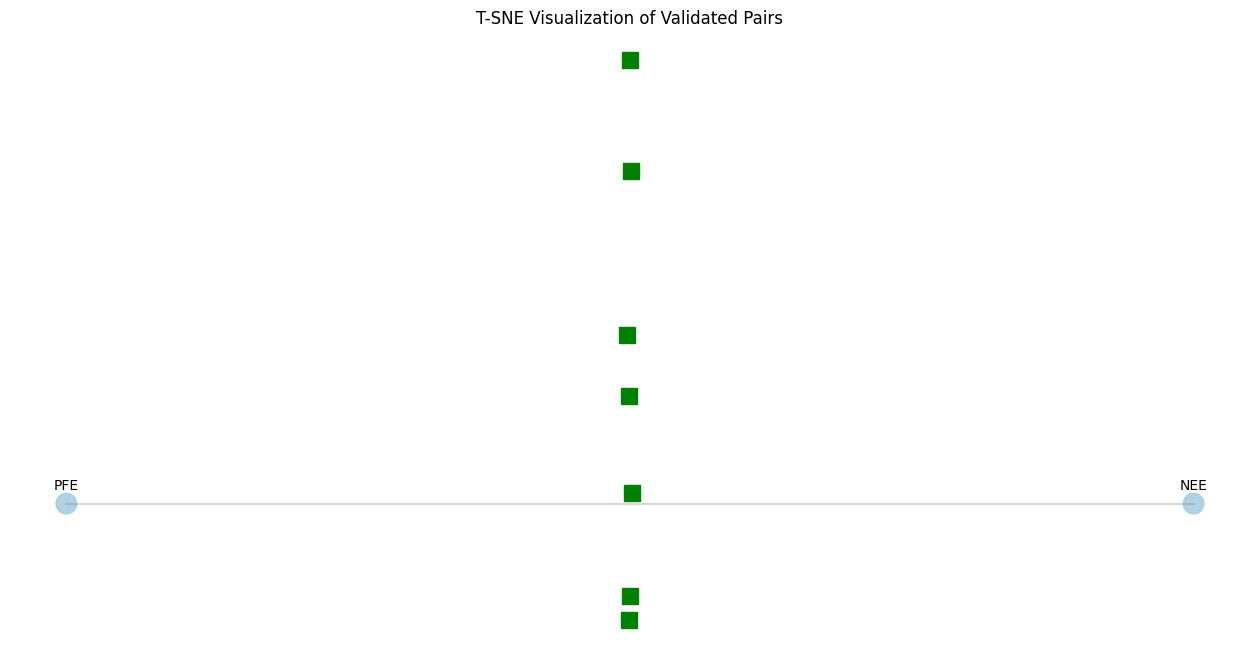

In [43]:
plt.figure(1, facecolor='white',figsize=(16,8))
plt.clf()
plt.axis('off')
for pair in pairs:
    #print(pair[0])
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    #print(ticker1, loc1)

    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs'); 

# zip joins x and y coordinates in pairs
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)


<a id='7'></a>
# 7. Implement a Pairs Trading Methodology 

Now that the clustering algorithm has identified a possible pairs trading opportunity, we can implement the pairs-trading methodology implemented [here](https://github.com/williamzjasmine/CUNY_SPS_DS/blob/master/DATA_618/Major_Assignments/Pairs_Trading/Portfolio_Pairs_Trading_Opportunities.ipynb) in order to see if we can generate any profit. The cell below determines all the instances over the past three years in which we should have initiated a trade, what kind of trade it should be, and when to close out. 

In [44]:
z_threshold = 1.5
df = dataset.reset_index()[['Date', 'NEE', 'PFE']]

df.columns = ['Date', 'A1', 'A2']
#df = df[df['Date'] >= dt.date(2022, 1, 1)].reset_index()
n = np.log(df['A1'].iloc[0]) / np.log(df['A2'].iloc[0])

df['S'] = np.log(df['A1']) - n * np.log(df['A2'])
df['S_mean'] = df['S'].expanding().mean()
df['S_std'] = df['S'].expanding().std()
df['z'] = (df['S'] - df['S_mean']) / df['S_std']

breaks = []

for index, row in df.iterrows():
    date = row['Date']
    z = row['z']
    A2 = row['A2']
    A1 = row['A1']
    mean = row['S_mean']
    
    if z > z_threshold and df.iloc[index-1]['z'] <= z_threshold:
        print(f'Indicator broken at {date}: z = {z}')
        tmp = df.iloc[index:]
        if mean > 0:
            tmp = tmp[tmp['S_mean'] < 0]
            if tmp.shape[0] > 0:
                tmp = tmp.iloc[0]
                breaks.append([date, tmp['Date'], A1, A2, 'shortlong', tmp['A1'], tmp['A2']])
            else:
                breaks.append([date, None, A1, A2, 'shortlong', None, None])
        else:
            tmp = tmp[tmp['S_mean'] > 0]
            if tmp.shape[0] > 0:
                tmp = tmp.iloc[0]
                breaks.append([date, tmp['Date'], A1, A2, 'shortlong', tmp['A1'], tmp['A2']])
            else:
                breaks.append([date, None, A1, A2, 'shortlong', None, None])
            
    if z < -z_threshold and df.iloc[index-1]['z'] >= -z_threshold:
        print(f'Indicator broken at {date}: z = {z}')
        tmp = df.iloc[index:]
        if mean > 0:
            tmp = tmp[tmp['S_mean'] < 0] 
            if tmp.shape[0] > 0:
                tmp = tmp.iloc[0]
                breaks.append([date, tmp['Date'], A1, A2, 'longshort', tmp['A1'], tmp['A2']])
            else:
                breaks.append([date, None, A1, A2, 'longshort', None, None])
        else:
            tmp = tmp[tmp['S_mean'] > 0]
            if tmp.shape[0] > 0:
                tmp = tmp.iloc[0]
                breaks.append([date, tmp['Date'], A1, A2, 'shortlong', tmp['A1'], tmp['A2']])
            else:
                breaks.append([date, None, A1, A2, 'shortlong', None, None])
        
breaks = pd.DataFrame(breaks, columns=['start_date', 'end_date', 'A1i', 'A2i', 'type', 'A1f', 'A2f'])
breaks.dropna()

Indicator broken at 2020-12-22: z = 1.6830581638414468
Indicator broken at 2020-12-28: z = 1.6539489203414874
Indicator broken at 2020-12-30: z = 1.5811797080093144
Indicator broken at 2021-01-06: z = 2.046980177744717
Indicator broken at 2021-01-13: z = 2.0515660724514944
Indicator broken at 2021-02-02: z = 1.6357990997850846
Indicator broken at 2021-02-11: z = 1.5758148472740645
Indicator broken at 2021-03-18: z = -1.5620924517019086
Indicator broken at 2021-04-21: z = -1.8329985772334578
Indicator broken at 2021-04-28: z = -1.5356791108110621
Indicator broken at 2021-05-03: z = -2.01963896765285
Indicator broken at 2021-06-04: z = -1.5402571674292007
Indicator broken at 2021-06-09: z = -1.6800089870797081
Indicator broken at 2021-07-28: z = -1.6587695039773545
Indicator broken at 2021-11-05: z = -1.5779583215477222
Indicator broken at 2021-11-10: z = -1.6707506494925444
Indicator broken at 2021-12-10: z = -1.5859211494230885
Indicator broken at 2022-03-14: z = -1.5366195536511422
In

,start_date,end_date,A1i,A2i,type,A1f,A2f
0,2020-12-22,2021-08-25,69.767830,32.758144,shortlong,79.771881,43.635338
1,2020-12-28,2021-08-25,70.496231,32.829475,shortlong,79.771881,43.635338
2,2020-12-30,2021-08-25,70.888451,32.758144,shortlong,79.771881,43.635338
3,2021-01-06,2021-08-25,73.241745,32.874050,shortlong,79.771881,43.635338
4,2021-01-13,2021-08-25,76.426186,32.865135,shortlong,79.771881,43.635338
5,2021-02-02,2021-08-25,77.444084,31.537203,shortlong,79.771881,43.635338
6,2021-02-11,2021-08-25,78.396606,31.032465,shortlong,79.771881,43.635338
7,2021-03-18,2021-08-25,66.773186,32.240227,longshort,79.771881,43.635338
8,2021-04-21,2021-08-25,73.194237,35.629196,longshort,79.771881,43.635338
9,2021-04-28,2021-08-25,72.368126,34.980251,longshort,79.771881,43.635338


`A1` in this case corresponds to `NEE` stock, while `A2` corresponds to `PFE`. The function below can be used to evaluate proposed trades above to determine if they result in any profit in the long term.

In [45]:
def calc_profit(p1i, p1f, p2i, p2f, trade_type, trade_amount):
    money_spent = 0
    money_made = 0
    p2_buy = 0
    p1_borrow = 0
    p2_borrow = 0 
    p1_buy = 0
    
    if trade_type == 'shortlong':
        money_spent += trade_amount
        money_made += trade_amount
        p2_buy = trade_amount / p2i
        p1_borrow = trade_amount / p1i
        
        money_spent += p1_borrow * p1f
        money_made += p2_buy * p2f
        return((money_spent, money_made))
    
    elif trade_type == 'longshort':
        money_spent += trade_amount
        money_made += trade_amount
        p1_buy = trade_amount / p1i
        p2_borrow = trade_amount / p2i
        
        money_spent += p2_borrow * p2f
        money_made += p1_buy * p1f
        return((money_spent, money_made))
    else:
        return 'invalid trade type'

The cell below uses this function on the proposed trades shown above by taking hypothetical $100 short and long positions for the instructed asset of each trade.

In [46]:
money_spent = 0
money_made = 0 
valid_trades = breaks.dropna()

for index, row in valid_trades.iterrows():
    ms, mm = calc_profit(row['A1i'], row['A1f'], row['A2i'], row['A2f'], row['type'], 100)
    money_spent += ms
    money_made += mm
profit = money_made - money_spent

In [47]:
print(f'Money made: ${money_made:,.2f}')
print(f'Money spent: ${money_spent:,.2f}')
print(f'Profit: ${profit:,.2f}')

Money made: $3,135.38
Money spent: $3,015.40
Profit: $119.99


The results above show that the pairs trading strategy determined above would have resulted in a net gain of ~$120 dollars, which is about 4\% of the amount used to make all the trades.

<a id='8'></a>
# 8. Conclusion

The clustering techniques do not directly help in stock trend prediction. However, they can be effectively used in portfolio construction for finding the right pairs, which eventually help in risk mitigation and one can achieve superior risk adjusted returns.

In this case, the clustering algorithm identified a pair of stocks (NEE and PFE) that would have generated a small profit after the implementation of a rudimentary pairs-trading methodology. While the net profits of 4% isn't huge, it is much more significant when compared to the results shown [here](http://localhost:8888/notebooks/Pairs_Trading/Portfolio_Pairs_Trading_Opportunities.ipynb) when possible pairs of the same [portfolio](https://docs.google.com/spreadsheets/d/1EZj5M7dXGy-48i0PydZQa5gpUOYCQHDFRBlp_rU1sdo/edit#gid=1736594093) were identified via more "human" means (which never saw profits greater than 1%). Thus, we can conclude that the clustering algorithm did indeed assist in finding a more reasonable pair of assets for pairs-trading. Furthermore, the amount of money profited from the resultant pair would likely increase, should the pairs-trading methodology be improved. 